<li><b>Name:</b> Zihao Ren
<li>Analytics Goal: How we can segmentate the steam reviewer and what are there traits.
<li>ML algorithm: Kmeans ++

In [0]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import FeatureHasher
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import OneHotEncoder



In [0]:
spark = SparkSession.builder.config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1")\
                            .config("spark.network.timeout", "36000000000s")\
                            .config("spark.executor.heartbeatInterval", "36000000000s")\
                            .config('spark.driver.maxResultSize','16g')\
                            .config('spark.default.parallelism', 8)\
                            .config('spark.sql.shuffle.partitions',8)\
                            .config('spark.driver.memory', '16g')\
                            .appName("Roger")\
                            .getOrCreate()

In [0]:
database = 'steam'
collection = 'steam'
user_name = 'roger'
password = 'roger'
address = 'gogogo.chu66.mongodb.net'
connection_string = f"mongodb+srv://{user_name}:{password}@{address}/{database}.{collection}"

In [0]:
df = spark.read.format("mongo").option("uri",connection_string).load()

In [0]:
df.cache()

Out[10]: DataFrame[_id: struct<oid:string>, achievements: int, appid: int, average_playtime: double, categories: string, developer: string, english: int, genres: string, median_playtime: double, name: string, negative_ratings: int, num_games_owned: int, num_reviews: int, owners: string, platforms: string, playtime_at_review: int, playtime_forever: int, positive_ratings: int, price: double, publisher: string, release_date: timestamp, required_age: int, review: string, steamid: bigint, steamspy_tags: string, timestamp_created: timestamp, timestamp_updated: timestamp, voted_up: boolean, votes_funny: int, votes_up: int, weighted_vote_score: int]

In [0]:
df.printSchema()

root
-- _id: struct (nullable = true)
 |-- oid: string (nullable = true)
-- achievements: integer (nullable = true)
-- appid: integer (nullable = true)
-- average_playtime: double (nullable = true)
-- categories: string (nullable = true)
-- developer: string (nullable = true)
-- english: integer (nullable = true)
-- genres: string (nullable = true)
-- median_playtime: double (nullable = true)
-- name: string (nullable = true)
-- negative_ratings: integer (nullable = true)
-- num_games_owned: integer (nullable = true)
-- num_reviews: integer (nullable = true)
-- owners: string (nullable = true)
-- platforms: string (nullable = true)
-- playtime_at_review: integer (nullable = true)
-- playtime_forever: integer (nullable = true)
-- positive_ratings: integer (nullable = true)
-- price: double (nullable = true)
-- publisher: string (nullable = true)
-- release_date: timestamp (nullable = true)
-- required_age: integer (nullable = true)
-- review: string (nullable = true)
-- steamid: long (nullable = true)
-- steamspy_tags: string (nullable = true)
-- timestamp_created: timestamp (nullable = true)
-- timestamp_updated: timestamp (nullable = true)
-- voted_up: boolean (nullable = true)
-- votes_funny: integer (nullable = true)
-- votes_up: integer (nullable = true)
-- weighted_vote_score: integer (nullable = true)

In [0]:
df.count()

Out[10]: 11296070

# K-means

In [0]:
df=df.dropna()

In [0]:
df = df.drop('_id','review','steamspy_tags')

In [0]:
def indexStringColumns(df, cols):
    # variable newdf will be updated several times
    newdf = df
    
    for c in cols:
        # For each given colum, fits StringIndexerModel.
        si = StringIndexer(inputCol=c, outputCol=c+"-num")#estimator
        sm = si.fit(newdf)# transformer
        
        # Creates a DataFame by putting the transformed values in the new colum with suffix "-num" 
        # and then drops the original columns.
        # and drop the "-num" suffix. 
        newdf = sm.transform(newdf).drop(c)
        newdf = newdf.withColumnRenamed(c+"-num", c)
    return newdf

In [0]:
def oneHotEncodeColumns(df, cols):
    newdf = df
    for c in cols:
        # For each given colum, create OneHotEncoder. 
        # dropLast : Whether to drop the last category in the encoded vector (default: true)
        ohe = OneHotEncoder(inputCol=c, outputCol=c+"-onehot", dropLast=False)
        ohe_model = ohe.fit(newdf)
        #Creates a DataFame by putting the transformed values in the new colum with suffix "-onehot" 
        #and then drops the original columns.
        #and drop the "-onehot" suffix. 
        newdf = ohe_model.transform(newdf).drop(c)#drop the column
        newdf = newdf.withColumnRenamed(c+"-onehot", c)
    return newdf

In [0]:
dfnumeric = indexStringColumns(df,['appid','english','categories', 'developer', 'genres','name', 'owners','platforms' ,'publisher'])


In [0]:
df_one = oneHotEncodeColumns(dfnumeric, ['appid','english','categories', 'developer', 'genres','name', 'owners','platforms' ,'publisher'])  

In [0]:
va = VectorAssembler(outputCol="features", inputCols=['achievements','appid','average_playtime','english',
                                                      'median_playtime',
                                                      'negative_ratings',
                                                      'num_games_owned',
                                                      'num_reviews',
                                                      'playtime_at_review',
                                                      'playtime_forever',
                                                      'positive_ratings',
                                                      'price',
                                                      'required_age',
                                                      'voted_up',
                                                      'votes_funny',
                                                      'votes_up',
                                                      'weighted_vote_score',
                                                      'categories',
                                                      'developer',
                                                      'genres',
                                                      'name',
                                                      'owners',
                                                      'platforms',
                                                      'publisher'])  # except the last col.
df_1_feature = va.transform(df_one)

In [0]:
#Apply K++
def K_means(df, center=2):
    kmeans =  KMeans(k = center, maxIter = 50, tol = 0.1,seed=2) 
    model = kmeans.fit(df)
    predictions = model.transform(df)
    evaluator = ClusteringEvaluator()
    silhouette = evaluator.evaluate(predictions)
    return center,silhouette,predictions

In [0]:
df_model = df_1_feature.select('features')

In [0]:
hetero_lst0 = []
center_lst0 = []
predict_df_lst0= []
for i in range(2, 15):
    center, silhouette,pred_df = K_means(df_model, i)
    hetero_lst0.append(silhouette)
    center_lst0.append(center)
    predict_df_lst0.append(pred_df)

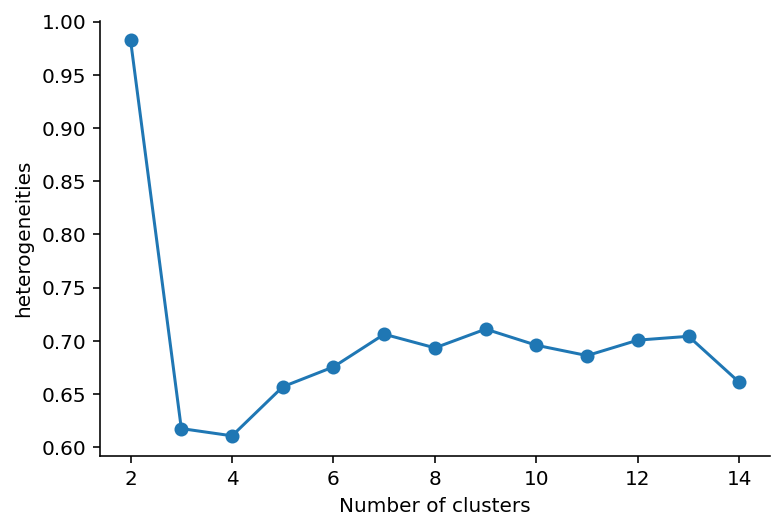

In [0]:
fig, ax = plt.subplots(figsize=(6,4))
plt.plot(range(2, 15), hetero_lst0, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('heterogeneities')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.annotate('Our K',
(1.3, 11000),
c='#E15F32',
size=12, weight='bold')
plt.show()

From the elbow method, we can divide our steam review into 4 categories.

# Analysis of each categories

In [0]:
center, silhouette,pred_df = K_means(df_model,4)

In [0]:
#join the pred_df with label. Get old information
df_trained = df_1_feature.join(pred_df,how='left_outer',on='features')

In [0]:
df_trained.show(5)

+--------------------+------------+----------------+---------------+----------------+---------------+-----------+------------------+----------------+----------------+-----------------+-------------------+------------+-----------------+-------------------+-------------------+--------+-----------+--------+-------------------+----------------+-------------+----------------+----------------+---------------+----------------+--------------+-------------+----------------+----------+
 features|achievements|average_playtime|median_playtime|negative_ratings|num_games_owned|num_reviews|playtime_at_review|playtime_forever|positive_ratings| price| release_date|required_age| steamid| timestamp_created| timestamp_updated|voted_up|votes_funny|votes_up|weighted_vote_score| appid| english| categories| developer| genres| name| owners| platforms| publisher|prediction|
+--------------------+------------+----------------+---------------+----------------+---------------+-----------+------------------+----------------+----------------+-----------------+-------------------+------------+-----------------+-------------------+-------------------+--------+-----------+--------+-------------------+----------------+-------------+----------------+----------------+---------------+----------------+--------------+-------------+----------------+----------+
(28367,[0,1,8138,...| 167| 22494.0| 6502.0| 402313| 86| 3| 77960| 113280| 2644404| 0.0|2012-08-21 00:00:00| 0|76561198086920055|2016-11-24 17:25:40|2016-11-24 17:25:40| true| 0| 1| 0|(8137,[0],[1.0])|(2,[0],[1.0])|(1947,[0],[1.0])|(5398,[0],[1.0])|(784,[2],[1.0])|(8135,[0],[1.0])|(13,[5],[1.0])|(5,[1],[1.0])|(3931,[0],[1.0])| 1|
(28367,[0,1,8138,...| 167| 22494.0| 6502.0| 402313| 7| 2| 5344| 8819| 2644404| 0.0|2012-08-21 00:00:00| 0|76561198211586393|2018-09-13 22:41:28|2018-09-13 22:41:28| true| 0| 0| 0|(8137,[0],[1.0])|(2,[0],[1.0])|(1947,[0],[1.0])|(5398,[0],[1.0])|(784,[2],[1.0])|(8135,[0],[1.0])|(13,[5],[1.0])|(5,[1],[1.0])|(3931,[0],[1.0])| 1|
(28367,[0,1,8138,...| 167| 22494.0| 6502.0| 402313| 16| 1| 81075| 161081| 2644404| 0.0|2012-08-21 00:00:00| 0|76561198839820249|2018-09-13 21:51:11|2019-07-02 11:52:06| true| 0| 0| 0|(8137,[0],[1.0])|(2,[0],[1.0])|(1947,[0],[1.0])|(5398,[0],[1.0])|(784,[2],[1.0])|(8135,[0],[1.0])|(13,[5],[1.0])|(5,[1],[1.0])|(3931,[0],[1.0])| 1|
(28367,[0,4,8138,...| 29| 12422.0| 1875.0| 16433| 256| 21| 5102| 5526| 363721|6.989999771118164|2006-11-29 00:00:00| 0|76561198062434897|2017-02-01 02:31:38|2017-02-01 02:31:38| true| 1| 1| 0|(8137,[3],[1.0])|(2,[0],[1.0])|(1947,[5],[1.0])|(5398,[1],[1.0])|(784,[4],[1.0])|(8135,[3],[1.0])|(13,[6],[1.0])|(5,[1],[1.0])|(3931,[0],[1.0])| 2|
(28367,[0,4,8138,...| 29| 12422.0| 1875.0| 16433| 38| 1| 10884| 11134| 363721|6.989999771118164|2006-11-29 00:00:00| 0|76561198422988638|2020-04-07 02:03:17|2020-04-07 02:03:17| true| 0| 0| 0|(8137,[3],[1.0])|(2,[0],[1.0])|(1947,[5],[1.0])|(5398,[1],[1.0])|(784,[4],[1.0])|(8135,[3],[1.0])|(13,[6],[1.0])|(5,[1],[1.0])|(3931,[0],[1.0])| 2|
+--------------------+------------+----------------+---------------+----------------+---------------+-----------+------------------+----------------+----------------+-----------------+-------------------+------------+-----------------+-------------------+-------------------+--------+-----------+--------+-------------------+----------------+-------------+----------------+----------------+---------------+----------------+--------------+-------------+----------------+----------+
only showing top 5 rows

In [0]:
df_trained.cache()

Out[28]: DataFrame[features: vector, achievements: int, average_playtime: double, median_playtime: double, negative_ratings: int, num_games_owned: int, num_reviews: int, playtime_at_review: int, playtime_forever: int, positive_ratings: int, price: double, release_date: timestamp, required_age: int, steamid: bigint, timestamp_created: timestamp, timestamp_updated: timestamp, voted_up: boolean, votes_funny: int, votes_up: int, weighted_vote_score: int, appid: vector, english: vector, categories: vector, developer: vector, genres: vector, name: vector, owners: vector, platforms: vector, publisher: vector, prediction: int]

In [0]:
df_trained.show(5)

+--------------------+------------+------+----------------+-------+---------------+----------------+---------------+-----------+------------------+----------------+----------------+----------------+-------------------+------------+-----------------+-------------------+-------------------+--------+-----------+--------+-------------------+----------------+-----------------+---------------+------------------+--------------+-------------+-----------------+----------+
 features|achievements| appid|average_playtime|english|median_playtime|negative_ratings|num_games_owned|num_reviews|playtime_at_review|playtime_forever|positive_ratings| price| release_date|required_age| steamid| timestamp_created| timestamp_updated|voted_up|votes_funny|votes_up|weighted_vote_score| categories| developer| genres| name| owners| platforms| publisher|prediction|
+--------------------+------------+------+----------------+-------+---------------+----------------+---------------+-----------+------------------+----------------+----------------+----------------+-------------------+------------+-----------------+-------------------+-------------------+--------+-----------+--------+-------------------+----------------+-----------------+---------------+------------------+--------------+-------------+-----------------+----------+
(20230,[0,1,2,3,4...| 43|883710| 841.0| 1| 843.0| 1075| 29| 11| 8473| 18459| 24950|44.9900016784668|2019-01-24 00:00:00| 18|76561198283281854|2019-06-19 09:50:44|2019-06-19 09:50:44| true| 24| 243| 0|(1947,[1],[1.0])|(5398,[14],[1.0])|(784,[0],[1.0])|(8135,[103],[1.0])|(13,[1],[1.0])|(5,[0],[1.0])|(3931,[18],[1.0])| 0|
(20230,[0,1,2,3,4...| 43|883710| 841.0| 1| 843.0| 1075| 30| 3| 852| 3721| 24950|44.9900016784668|2019-01-24 00:00:00| 18|76561198049049146|2019-01-26 08:46:37|2019-01-26 08:46:37| true| 1| 5| 0|(1947,[1],[1.0])|(5398,[14],[1.0])|(784,[0],[1.0])|(8135,[103],[1.0])|(13,[1],[1.0])|(5,[0],[1.0])|(3931,[18],[1.0])| 0|
(20230,[0,1,2,3,4...| 43|883710| 841.0| 1| 843.0| 1075| 39| 1| 2983| 6514| 24950|44.9900016784668|2019-01-24 00:00:00| 18|76561198074525183|2019-02-15 06:03:51|2019-02-15 06:03:51| true| 1| 1| 0|(1947,[1],[1.0])|(5398,[14],[1.0])|(784,[0],[1.0])|(8135,[103],[1.0])|(13,[1],[1.0])|(5,[0],[1.0])|(3931,[18],[1.0])| 0|
(20230,[0,1,2,3,4...| 43|883710| 841.0| 1| 843.0| 1075| 50| 1| 637| 1309| 24950|44.9900016784668|2019-01-24 00:00:00| 18|76561198840134146|2021-03-02 02:56:52|2021-03-02 03:02:12| true| 3| 5| 0|(1947,[1],[1.0])|(5398,[14],[1.0])|(784,[0],[1.0])|(8135,[103],[1.0])|(13,[1],[1.0])|(5,[0],[1.0])|(3931,[18],[1.0])| 0|
(20230,[0,1,2,3,4...| 43|883710| 841.0| 1| 843.0| 1075| 54| 2| 3004| 4167| 24950|44.9900016784668|2019-01-24 00:00:00| 18|76561198129800916|2020-09-01 18:44:56|2020-09-01 18:44:56| true| 2| 1| 0|(1947,[1],[1.0])|(5398,[14],[1.0])|(784,[0],[1.0])|(8135,[103],[1.0])|(13,[1],[1.0])|(5,[0],[1.0])|(3931,[18],[1.0])| 0|
+--------------------+------------+------+----------------+-------+---------------+----------------+---------------+-----------+------------------+----------------+----------------+----------------+-------------------+------------+-----------------+-------------------+-------------------+--------+-----------+--------+-------------------+----------------+-----------------+---------------+------------------+--------------+-------------+-----------------+----------+
only showing top 5 rows

In [0]:
df_trained.groupby(['prediction']).agg(avg(col("voted_up").cast("double")).alias('percent_up'),round(avg('average_playtime'),2).alias('avg_play_time'))\
 .orderBy('prediction').show(5)

+----------+------------------+-------------+
prediction| percent_up|avg_play_time|
+----------+------------------+-------------+
 0|0.8675449771618556| 3270.87|
 1|0.8888177986345027| 22494.0|
 2|0.8808196535905903| 2468.35|
 3| 0.911339103687669| 5229.67|
+----------+------------------+-------------+

In [0]:
df_trained.columns

Out[31]: ['features',
 'achievements',
 'average_playtime',
 'median_playtime',
 'negative_ratings',
 'num_games_owned',
 'num_reviews',
 'playtime_at_review',
 'playtime_forever',
 'positive_ratings',
 'price',
 'release_date',
 'required_age',
 'steamid',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_funny',
 'votes_up',
 'weighted_vote_score',
 'appid',
 'english',
 'categories',
 'developer',
 'genres',
 'name',
 'owners',
 'platforms',
 'publisher',
 'prediction']

In [0]:
df_trained.groupby(['prediction']).agg(avg(col("voted_up")).alias('percent_up'),round(avg('average_playtime'),2).alias('avg_play_time'))\
 .orderBy('prediction').show(5)

In [0]:
df_trained.groupby(['prediction']).count().show(5)

+----------+-------+
prediction| count|
+----------+-------+
 3|2825823|
 1| 826805|
 2|5552736|
 0|2091895|
+----------+-------+

In [0]:
df_trained.columns

Out[37]: ['features',
 'achievements',
 'average_playtime',
 'median_playtime',
 'negative_ratings',
 'num_games_owned',
 'num_reviews',
 'playtime_at_review',
 'playtime_forever',
 'positive_ratings',
 'price',
 'release_date',
 'required_age',
 'steamid',
 'timestamp_created',
 'timestamp_updated',
 'voted_up',
 'votes_funny',
 'votes_up',
 'weighted_vote_score',
 'appid',
 'english',
 'categories',
 'developer',
 'genres',
 'name',
 'owners',
 'platforms',
 'publisher',
 'prediction']

In [0]:
df_trained.groupby(['prediction']).agg(avg(col("votes_up")).alias('votes_up_avg'),round(avg('price'),2).alias('avg_price'),avg('num_reviews').alias('avg_num_reviews'),avg('num_games_owned').alias('games_owned'))\
 .orderBy('prediction').show(5)
#price = 0 means these group of user majorly play free games

+----------+------------------+---------+------------------+------------------+
prediction| votes_up_avg|avg_price| avg_num_reviews| games_owned|
+----------+------------------+---------+------------------+------------------+
 0|1.6293406264325647| 16.55|18.337677496086393|209.01789855987784|
 1|0.5533614334698024| 0.0| 4.11419137523358| 65.16239258349913|
 2|0.8435607872513479| 15.93| 7.5651088190406| 98.36473064754317|
 3|1.3122014246188556| 20.88| 9.853918886644713|139.56692422382093|
+----------+------------------+---------+------------------+------------------+